# CSE 6240 - Web Search & Text Mining - Homework 3

In [1]:
# __author__ = 'Bhanu Verma'
# GTid = '903151012'

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import os, os.path
from scipy.sparse import lil_matrix,linalg
from scipy.sparse import csr_matrix
from scipy.sparse import identity
from scipy.sparse.linalg import norm,svds
from scipy.sparse.linalg import eigs,eigsh
from sklearn.cross_validation import train_test_split
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import time
import pprint
%matplotlib inline

In [3]:
def get_matrix_dimensions():
    doc_size = 0
    vocab_size = 0
    with open(filepath, "r") as f:
        count = 0
        for line in f:
            line = line.rstrip('\n')
            if count==0:
                doc_size = int(line)
            elif count==1:
                vocab_size = int(line)
            else:
                break
                
            count+=1
    
    f.close()
    
    return (doc_size,vocab_size)

In [4]:
def populate_matrix():
    with open(filepath, "r") as f:
        count = 0
        for line in f:
            line = line.rstrip('\n')
            if count > 2:
                arr = line.split()
                i = int(arr[0])-1
                j = int(arr[1])-1
                val = int(arr[2])
                mat[i,j] = val
            count+=1
    f.close()

In [5]:
def get_triplet_list():
    triplet_list = []
    ordered_list = []
    for i in range(n_doc):
        # randomly generate 6 numbers, 1 extra to take care of the case where random number id is equal to i
        rand_arr = np.random.choice(n_doc,6,replace=False)
        doc_list = [] # list of indices of documents
        corr_val = [] # list of calculated correlation coefficients
        tuple_list = []
        
        # fill up correlation values
        for j in range(len(rand_arr)):
            if i!=j:
                a = get_dense_row(i)
                b = get_dense_row(rand_arr[j])
                pear_val = pearsonr(a,b) # it returns a tuple where first element is the coefficient value
                corr_val.append(pear_val[0])
                doc_list.append(rand_arr[j])
                if len(corr_val) == 5:
                    break

        # build up triplets
        for a in range(len(corr_val)):
            for b in range(a+1,len(corr_val)):
                if b < len(corr_val):
                    if corr_val[a] >= corr_val[b]:
                        triplet_list.append((i,doc_list[a],doc_list[b]))
                        tuple_list.append((i,doc_list[a],doc_list[b]))
                    else:
                        triplet_list.append((i,doc_list[b],doc_list[a]))
                        tuple_list.append((i,doc_list[b],doc_list[a]))
        
    return triplet_list

In [6]:
def get_dense_row(index):
    return dense_mat[index].tolist()[0] # fix for the issue, tolist() here returns matrix of rowsize 1

In [7]:
def get_sparse_row(index):
    return mat[index]

In [8]:
def dense(sparse):
    sparse = sparse.todense()
    return sparse[0].tolist()[0]

# Question 2.a - Generating Correlated Triplets

In [9]:
# get matrix dimensions
filepath = 'Data/docword.kos.txt'
size_tup = get_matrix_dimensions()

In [10]:
n_doc = size_tup[0]
n_vocab = size_tup[1]

In [11]:
# populate lil_matrix dimensions
mat = lil_matrix((size_tup[0],size_tup[1]),dtype=np.int32)
populate_matrix()

# convert lil_matrix to csr matrix for faster computation
mat = mat.tocsr()
dense_mat = mat.todense()

In [12]:
triplets = get_triplet_list()

In [13]:
# split triplet array into training and testing data
train,test = train_test_split(triplets, train_size = 0.8, random_state=42)

# OASIS Implementation

In [14]:
w = identity(n_vocab,format='csr')
c = 0.1

In [15]:
def get_similarity_score(a,w_mat,b):
    result = a*w_mat*b
    return result[0,0]

In [16]:
def get_loss(a_i,a_plus,a_neg,w_mat):
    res_a = get_similarity_score(a_i,w_mat,a_plus.transpose())
    res_b = get_similarity_score(a_i,w_mat,a_neg.transpose())
    val = 1-res_a+res_b
    return max(0,val)

In [39]:
def make_psd(w_mat):
    # Make matrix positive semi-definite
    w, v = eigsh(w_mat,1000)  # eigvec in columns
    D = np.diagflat(np.maximum(w, 0.25))
    return csr_matrix(np.dot(np.dot(v, D), v.T))

In [38]:
def run_oasis(p_mat, train_data, test_data, w_mat, symmetric, pos_def=False):
    training_loss_list = []
    testing_loss_list = []
    
    if pos_def:
        train_size = 1
        iter_size = 50
    else:
        train_size = len(train_data)
        iter_size = 2740
        
    for i in range(train_size):
        p_i = p_mat[train_data[i][0]]
        p_plus = p_mat[train_data[i][1]]
        p_neg = p_mat[train_data[i][2]]

        loss = get_loss(p_i,p_plus,p_neg,w_mat)
        if (i%iter_size == 0 and not pos_def):
            print "number of iterations - ", i

        if loss != 0:
            diff = (p_plus - p_neg).transpose()
            ones = np.ones((n_vocab,n_vocab))
            diff_csr = csr_matrix(diff.multiply(ones))
            elements = csr_matrix(p_i.multiply(ones))
            v_i = elements.multiply(diff_csr).transpose()
            norm_val = norm(v_i, 'fro')**2 
            tau = min(c,loss/norm_val)
            w_mat = w_mat + tau*v_i
            if symmetric:
                w_mat = (w_mat + w_mat.transpose())/2
            if pos_def:
                w_mat = (w_mat + w_mat.transpose())/2
                w_mat = make_psd(w_mat)

        train_loss = 0
        test_loss = 0

        if (i%iter_size == 0):
            if (not pos_def):
                # calculate Training Loss
                for z in range(len(train_data)):
                    a_i = p_mat[train_data[z][0]]
                    a_plus = p_mat[train_data[z][1]]
                    a_neg = p_mat[train_data[z][2]]
                    train_loss += get_loss(a_i,a_plus,a_neg,w_mat)
                train_loss = train_loss/len(train_data)
                training_loss_list.append(train_loss)

                # calculate Testing Loss
                for k in range(len(test_data)):
                    t_i = p_mat[test_data[k][0]]
                    t_plus = p_mat[test_data[k][1]]
                    t_neg = p_mat[test_data[k][2]]
                    test_loss += get_loss(t_i,t_plus,t_neg,w_mat)
                test_loss = test_loss/len(test_data)
                testing_loss_list.append(test_loss)

                print "Training Error", train_loss
                print "Testing Error", test_loss
                print "-----------------------------"
            
    return w_mat, training_loss_list, testing_loss_list

# Question 1 - OASIS for non-symmetric W

If you look at the number of iterations, you will see that I am calculating training error per 2740 iterations which is 1/10th of the training data. BUT W IS BEING CACULATED FOR EVERY ITERATION. I used this approach to save on the run time.

NOTE - Earlier I was calculating training error per 200 iterations. My kernel died one day before submission which didn't leave me with much time to run it again for every 200 iterations

In [19]:
w,train_loss_arr,test_loss_arr = run_oasis(mat,train,test,w,False,False)

number of iterations -  0
Training Error 1.52281341108
Testing Error 1.56341107872
-----------------------------
number of iterations -  2740
Training Error 0.611494295222
Testing Error 0.719358454796
-----------------------------
number of iterations -  5480
Training Error 0.471853629944
Testing Error 0.609063173948
-----------------------------
number of iterations -  8220
Training Error 0.407642545965
Testing Error 0.580176775624
-----------------------------
number of iterations -  10960
Training Error 0.345699464572
Testing Error 0.551879769786
-----------------------------
number of iterations -  13700
Training Error 0.281326645836
Testing Error 0.510808596238
-----------------------------
number of iterations -  16440
Training Error 0.248157356469
Testing Error 0.502135451374
-----------------------------
number of iterations -  19180
Training Error 0.214484722345
Testing Error 0.49162703545
-----------------------------
number of iterations -  21920
Training Error 0.18499271295

# Question 2.b - Training Error Plot

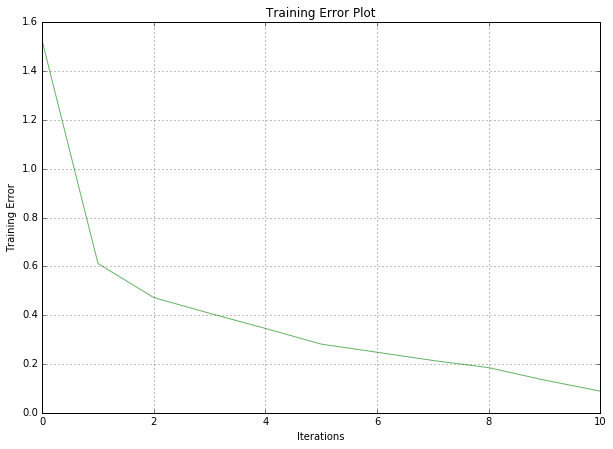

In [20]:
plt.figure(1, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Training Error')
plt.title('Training Error Plot')
plt.plot(train_loss_arr, color='green',alpha=0.6)
plt.grid(True)

# Question 2.c - Testing Error Plot

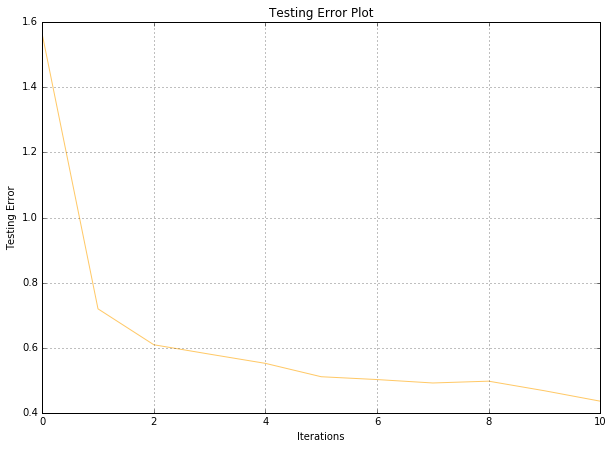

In [21]:
plt.figure(1, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Iterations')
plt.ylabel('Testing Error')
plt.title('Testing Error Plot')
plt.plot(test_loss_arr, color='orange',alpha=0.6)
plt.grid(True)

# Question 3 - OASIS for symmetric W

If you look at the number of iterations, you will see that I am calculating training error per 2740 iterations which is 1/10th of the training data. BUT W IS BEING CACULATED FOR EVERY ITERATION. I used this approach to save on the run time.

NOTE - Earlier I was calculating training error per 200 iterations. My kernel died one day before submission which didn't leave me with much time to run it again for every 200 iterations

In [30]:
w = identity(n_vocab,format='csr')
w_sym,train_loss_arr_sym,test_loss_arr_sym = run_oasis(mat,train,test,w,True,False)

number of iterations -  0
Training Error 1.52281341108
Testing Error 1.56341107872
-----------------------------
number of iterations -  2740
Training Error 0.689325754609
Testing Error 0.777004177627
-----------------------------
number of iterations -  5480
Training Error 0.555540825242
Testing Error 0.663594820612
-----------------------------
number of iterations -  8220
Training Error 0.505886168472
Testing Error 0.63942030322
-----------------------------
number of iterations -  10960
Training Error 0.458137739038
Testing Error 0.61131438241
-----------------------------
number of iterations -  13700
Training Error 0.400407861869
Testing Error 0.567286274688
-----------------------------
number of iterations -  16440
Training Error 0.376550341149
Testing Error 0.559130675997
-----------------------------
number of iterations -  19180
Training Error 0.363187486158
Testing Error 0.56830530544
-----------------------------
number of iterations -  21920
Training Error 0.333642676402


# Question 3.a - Testing & Training Error for symmetric W

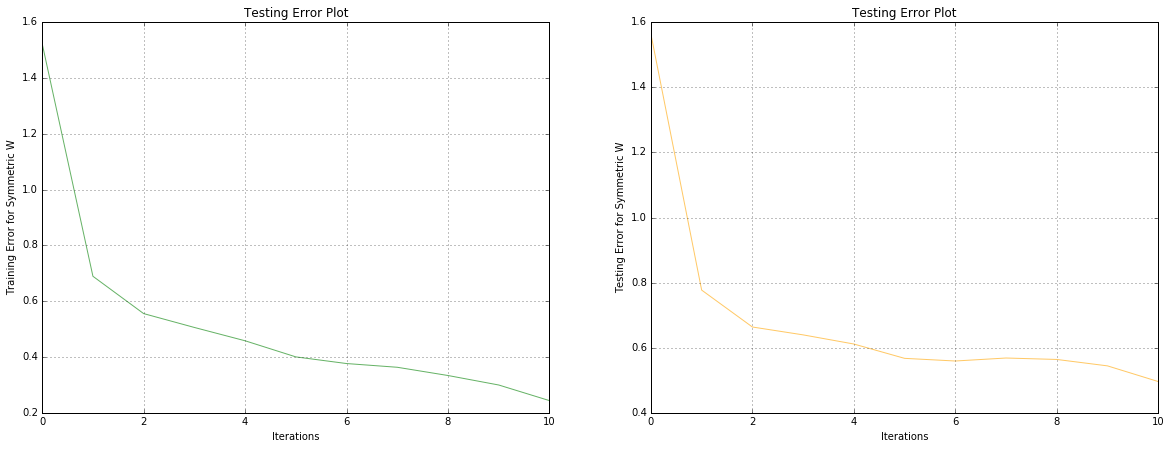

In [36]:
plt.figure(2, figsize=(20, 7))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Training Error for Symmetric W')
plt.title('Testing Error Plot')
plt.plot(train_loss_arr_sym, color='green',alpha=0.6)
plt.grid(True)

plt.subplot(1,2,2)
plt.xlabel('Iterations')
plt.ylabel('Testing Error for Symmetric W')
plt.title('Testing Error Plot')
plt.plot(test_loss_arr_sym, color='orange',alpha=0.6)
plt.grid(True)
plt.show()

# Question 3.b - Eigenvalues of the W matrix

In [34]:
start_time = time.time()
vals,vecs = eigsh(w_sym,k=n_vocab-1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 971.978242874 seconds ---


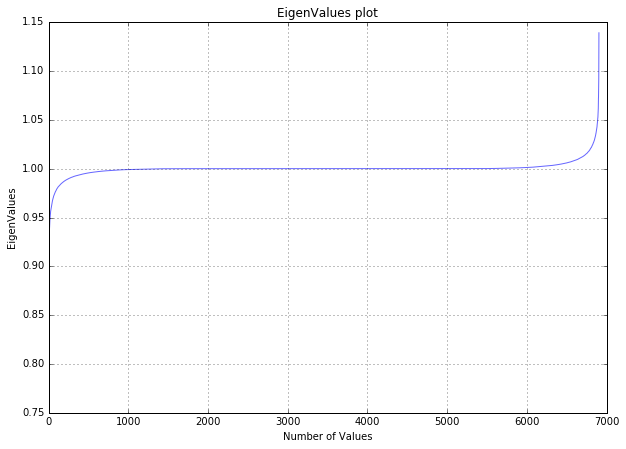

In [37]:
plt.figure(3, figsize=(10, 7))
plt.subplot(1,1,1)
plt.xlabel('Number of Values')
plt.ylabel('EigenValues')
plt.title('EigenValues plot')
plt.plot(vals, color='blue',alpha=0.6)
plt.grid(True)

# Question 3.c - Comment on the role of positive and negative eigenvalues

A matrix having a negative eigen value indicates represents a linear transform which acts as a reflection along some axis. This particularly means that whether a set of vectors that are oriented in a particular way, maintain that orientation or not.

All the eigen values in our current data set are positive. However, a negative eigen value,if present, indicates an inverse relationship between the factor and variable,.i.e, negative correlation.

Here, all the features are positively correlated to the dataset, and hence we do not observe negative values.

# Question 4 - OASIS for positive definite W

In [40]:
# w_psd,train_empty,test_empty = run_oasis(mat,train,test,w,True,True)
w_psd = w_sym # for our case as there are no negative eigenvalues, w_psd = w_sym

# Question 4.a - Find B

In [41]:
start_time = time.time()
u,s,vt = svds(w_psd,k=5)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.8952729702 seconds ---


In [42]:
print s

[ 1.08062075  1.08698535  1.09183727  1.11840794  1.13916254]


In [44]:
e = np.diagflat(s)
print e

[[ 1.08062075  0.          0.          0.          0.        ]
 [ 0.          1.08698535  0.          0.          0.        ]
 [ 0.          0.          1.09183727  0.          0.        ]
 [ 0.          0.          0.          1.11840794  0.        ]
 [ 0.          0.          0.          0.          1.13916254]]


In [45]:
e = np.sqrt(e)
print e

[[ 1.0395291   0.          0.          0.          0.        ]
 [ 0.          1.0425859   0.          0.          0.        ]
 [ 0.          0.          1.04491017  0.          0.        ]
 [ 0.          0.          0.          1.05754808  0.        ]
 [ 0.          0.          0.          0.          1.06731558]]


In [48]:
b = np.dot(u,e)
print b.shape

(6906, 5)


# Question 4.b - Every row of the B matrix is vectorization of every word. For every word compute its 5 nearest neighbors. Show 10 words where the neighbors make sense and other cases where the neighbors are wrong.

In [63]:
def get_euc_mat(mat):
    y = pdist(mat, metric='euclidean')
    euc_mat = squareform(y)
    return euc_mat

In [64]:
def get_neighbours(mat):
    neighbours = []
    for row_id in range(mat.shape[0]):
        temp_arr = mat[row_id]
        id_arr = np.argsort(temp_arr)
        temp_id = []
        for i,ind in enumerate(id_arr):
            if i>=1 and i<6:
                temp_id.append(ind)
            elif i>=6:
                break
        neighbours.append(temp_id)
    return neighbours

In [65]:
euc_mat = get_euc_mat(b)
nn_arr = get_neighbours(euc_mat)

In [62]:
print nn_arr[1]

[1, 4816, 3212, 3187, 3556]
